# Explore Whether Weighting Improves Generalizability
The stopping proces change by several order of magnitudes, which could cause problems with the model preferrentially fitting the regions with large forces.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
from stopping_power_ml.io import get_charge_density_interpolator
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LassoLars
from copy import deepcopy
import pandas as pd
import pickle as pkl
import numpy as np
import os

## Load in the Data and Model
Get both the random trajectory and the channel

In [3]:
random_data = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))
print('Data set size:', len(random_data))

Data set size: 9800


In [4]:
channel_data = pd.read_pickle(os.path.join('data', 'channel_data.pkl.gz'))

In [5]:
featurizers = pkl.load(open(os.path.join('..', 'featurizers.pkl'), 'rb'))[:-1]

In [6]:
model = GridSearchCV(Pipeline([
    ('lasso_rfe', SelectFromModel(
        LassoLars(normalize=True, max_iter=22, fit_intercept=False, alpha=1e-10))
    ),
    ('model', Ridge())
]), {'lasso_rfe__estimator__max_iter':range(5,30),
    'model__alpha': np.logspace(-10, 0, 10)})

In [7]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [8]:
X_cols = sum([f.feature_labels() for f in featurizers], [])

## Set up the Test
The plan is to train on 75% of the random trajectory. 

In [9]:
def run_test(weight_function, train_fraction=0.75):
    """Evaluate performance of model on random and channel trajectory
    
    Args:
        weight_function - Takes list of floats as input, returns weights
            as list of pre-SAT 
        train_fraction - (float) fraction of random trajectory
    Returns:
        - Model trained on output data
    """
    
    # Make the training set
    train_ind = int(len(random_data) * train_fraction)
    train_data = random_data.iloc[:train_ind]
    
    # Train the model
    weights = weight_function(train_data['force'])
    my_model = deepcopy(model)
    my_model.fit(train_data[X_cols], train_data['force'], model__sample_weight=weights)
    
    # Run the model
    return my_model

In [10]:
unweighted_model = run_test(lambda x: [1]*len(x))

In [11]:
unweighted_model.best_params_

{'lasso_rfe__estimator__max_iter': 17, 'model__alpha': 1e-10}

Tools for plotting the results

In [12]:
def plot_random(ax, symlog=False, ylabel=False, **charts):
    """Plot the performance of a model on the random trajectory
    
    Kwargs:
        [label of chart]=([model to evaluate, color])"""
    
    ax.plot(random_data['timestep'], random_data['force'], 'k-', label='')
    
    for label, (model, color) in charts.items():
        ax.plot(random_data['timestep'], model.predict(random_data[X_cols]), label=label)
    
    if symlog:
        ax.set_xlim(2500, 4000)
        ax.set_yscale('symlog')
    else:
        ax.set_xlim(4000, 6500)
        ax.set_ylim(0, 0.4)

    ax.set_xlabel('Timestep', fontsize=18)
    if ylabel:
        ax.set_ylabel('Force ($E_H/a_B$)', fontsize=18)

In [13]:
def plot_channel(ax, **charts):
    """Plot the performance of a model on the random trajectory
    
    Kwargs:
        [label of chart]=([data to plot, color])"""
    
    ax.plot(channel_data['timestep'], channel_data['force'], 'k-', label='')
    
    for label, (model, color) in charts.items():
        ax.plot(channel_data['timestep'], model.predict(channel_data[X_cols]), label=label)
        
    ax.set_ylim(0.1, 0.4)
    
    ax.set_xlabel('Timestep', fontsize=18)

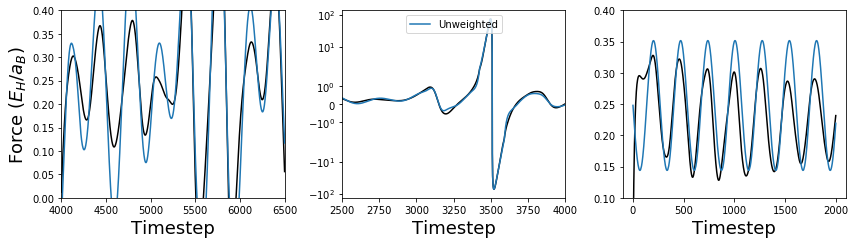

In [14]:
fig, ax = plt.subplots(1, 3)

plot_random(ax[0], ylabel=True, **{'Unweighted': (unweighted_model, 'r')})
plot_random(ax[1], symlog=True, **{'Unweighted': (unweighted_model, 'r')})
plot_channel(ax[2], **{'Unweighted': (unweighted_model, 'r')})

ax[1].set_ylabel('')

ax[1].legend(loc='upper center', ncol=2)

fig.set_size_inches(12, 3.5)
fig.tight_layout()

## Test Guassian Weight Strategies
We want to make the points closest to the mean to be most strongly weighted

In [15]:
def gaussian_weight(x, strength=1):
    """Weight by the distance from the mean using a Guassian
    
    w = np.exp(-1*(x-|x|)^2*strength)"""
    
    return np.exp(-strength * np.power(np.subtract(x, np.mean(x)), 2))

In [16]:
weighted_model = run_test(lambda x: gaussian_weight(x, 100))

In [17]:
weighted_model.best_params_

{'lasso_rfe__estimator__max_iter': 23, 'model__alpha': 1e-10}

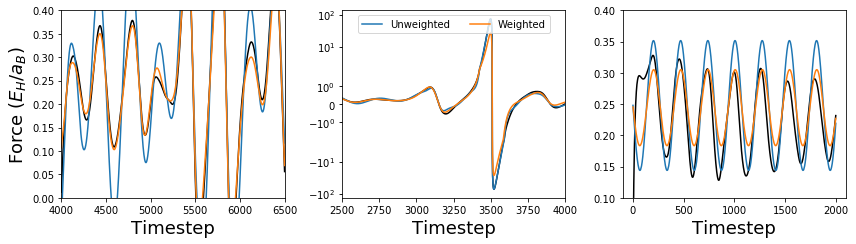

In [18]:
fig, ax = plt.subplots(1, 3)

models={
    'Unweighted': (unweighted_model, 'r'),
    'Weighted': (weighted_model, 'b')
}
plot_random(ax[0], ylabel=True, **models)
plot_random(ax[1], symlog=True, **models)
plot_channel(ax[2], **models)

ax[1].set_ylabel('')

ax[1].legend(loc='upper center', ncol=2)

fig.set_size_inches(12, 3.5)
fig.tight_layout()

*Finding*: It does not overshoot as much when we apply the weighing, but it does mess up the channel a little bit

### Find an optimal strength
Adjust until the fitness on the channel stops. We are going to look at timesteps 750-1250

In [19]:
strength = np.logspace(-4, 4, 17)

In [20]:
results = []
for s in tqdm(strength):
    weighted_model = run_test(lambda x: gaussian_weight(x, s))
    channel_out = weighted_model.predict(channel_data[X_cols])
    random_out = weighted_model.predict(random_data[X_cols])
    
    # Compute the results
    results.append({
        'strength': s,
        'random_mae': np.mean(np.abs(np.subtract(random_data['force'], random_out))[~ random_data['initial']]),
        'channel_mae': np.mean(np.abs(np.subtract(channel_data['force'], channel_out))[~ channel_data['initial']]),
        'random_stopping': np.mean(random_out),
        'channel_stopping': np.mean(channel_out)
    })

A Jupyter Widget

In [21]:
results = pd.DataFrame(results)

#### How does the error for the models change?
Do we see it getting worse for the random trajectory and better for the channel?

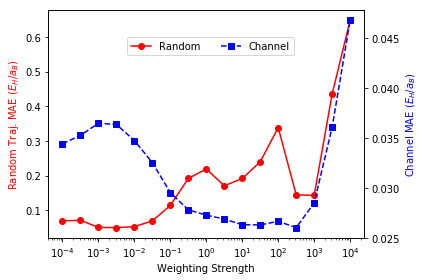

In [22]:
fig, ax = plt.subplots()

ax.plot(results['strength'], results['random_mae'], 'ro-', label='Random')

ax2 = ax.twinx()
ax2.plot(results['strength'], results['channel_mae'], 'bs--', label='Channel')

ax.set_xlabel('Weighting Strength')
ax.set_ylabel('Random Traj. MAE ($E_H/a_B$)', color='r')
ax2.set_ylabel('Channel MAE ($E_H/a_B$)', color='b')

ax.set_xscale('log')

fig.legend(loc=(0.3, 0.8), ncol=2)

fig.tight_layout()

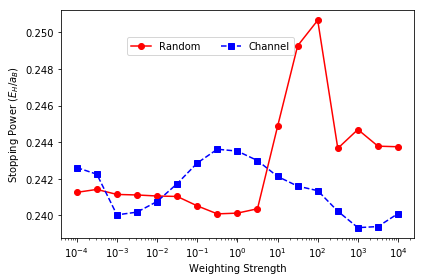

In [23]:
fig, ax = plt.subplots()

ax.plot(results['strength'], results['random_stopping'], 'ro-', label='Random')

ax.plot(results['strength'], results['channel_stopping'], 'bs--', label='Channel')

ax.set_xlabel('Weighting Strength')
ax.set_ylabel('Stopping Power ($E_H/a_B$)')

ax.set_xscale('log')

fig.legend(loc=(0.3, 0.8), ncol=2)

fig.tight_layout()

Save the best weight

In [24]:
best_weight = results['strength'][results['channel_mae'].idxmin()]

In [25]:
print('Best weight: {:2e}'.format(best_weight))

Best weight: 3.162278e+02


In [26]:
with open('best_weight.pkl', 'wb') as fp:
    pkl.dump(best_weight, fp)

In [27]:
best_model = run_test(lambda x: gaussian_weight(x, best_weight))

In [28]:
with open('best_model.pkl', 'wb') as fp:
    pkl.dump(best_model, fp)